In [2]:
# I would expect the 'null' map to be quite different than the 'real' map
# in the real map, kin are not distributed randomly.
# They tend to be CLOSE, i.e. in same region or neighboring region.

# can probably do some sort of clustering to show this

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# find kin pairs separated by some distance threshold
# ... or where region1 and region2 are NOT the same
# make matrix of connections between nuts3 in real ukb data

# from census pop, sample number of pairs
# make matrix of connections between nuts3 in simulated data

In [19]:
kinship = pd.read_csv('../prob_of_kin_within_D/kinship_data.csv')

In [20]:
kinship.head(3)

,uniqID,ID1,ID2,HetHet,IBS0,Kinship,pob_north_id1,pob_east_id1,pob_north_id2,pob_east_id2,distance,region1,region2
0,rel1,1000027,3239325,0.078,0.0041,0.2657,422500,438500,425500,442500,5000.000000,UKE45,UKE45
1,rel2,1000064,3178357,0.046,0.0138,0.0682,398500,451500,176500,318500,258791.421805,UKE31,UKL22
2,rel3,1000096,4107632,0.047,0.0137,0.0715,673500,327500,341500,456500,356181.133695,UKM25,UKF14


In [4]:
# find rows were region1 is not same as region2
different_nuts = kinship[kinship['region1'] != kinship['region2']]

In [5]:
different_nuts.head(3)
# eventually, turn these pairs into a matrix

,uniqID,ID1,ID2,HetHet,IBS0,Kinship,pob_north_id1,pob_east_id1,pob_north_id2,pob_east_id2,distance,region1,region2
1,rel2,1000064,3178357,0.046,0.0138,0.0682,398500,451500,176500,318500,258791.421805,UKE31,UKL22
2,rel3,1000096,4107632,0.047,0.0137,0.0715,673500,327500,341500,456500,356181.133695,UKM25,UKF14
6,rel7,1000230,3279718,0.041,0.0143,0.0443,168500,572500,669500,252500,594475.398986,UKJ41,UKM34


In [13]:
# convert regions to a dictionary = ukb_nuts3_pair_counts
# keys = sorted(region1,region2), vales = count of that pair
ukb_nuts3_pair_counts = {}
for i, r in different_nuts.iterrows():
    r1 = r['region1']
    r2 = r['region2']
    regions_key = ','.join(sorted([r1,r2]))
    if regions_key in ukb_nuts3_pair_counts.keys():
        ukb_nuts3_pair_counts[regions_key] += 1
    else:
        ukb_nuts3_pair_counts[regions_key] = 1 

In [6]:
print('kin in different regions', len(different_nuts))
print('all kin pairs', len(kinship))

kin in different regions 38967
all kin pairs 97692


UKB has 38967 pairs where kin are not in same nuts3 region  
function to make X# simulated pairs by sampling population based on census fractions  
and make a matrix of nuts3 by nuts3  
strategy: for num of pairs  
  * get sim_region_1, sim_region_2  
  * if different regions, 
   * sort region names 
   * count[region names] += 1

convert count dictionary into a matrix

In [7]:
# census_fracs = dictionary of nutsIDs => fraction of total population
# load in census data
nuts3_pops = pd.read_csv('/Users/ianwoods/Dropbox/sabbatical2019/nuts/nuts3_sampling_corrections.csv')

## nutsDict = a dictionary of indices => alphabetized nutsIDs
ind = np.arange(len(nuts3_pops))
nutsIDs = sorted(nuts3_pops['NUTS_ID'].values)
nutsDict = dict(zip(ind,nutsIDs))

## census_fracs_for_nuts = a dictionary of nutsIDs => census_fractions
census_pops = nuts3_pops['census_pops'].values
census_fracs = census_pops / np.sum(census_pops)
# force probabilities to sum to 1, for random choice below.
print('before force ', census_fracs[-1])
census_fracs[-1] = 1-np.sum(census_fracs[:-1])
print('after force  ',census_fracs[-1])
print(np.sum(census_fracs))

#dictionary = dict(zip(keys, values))
census_fracs_for_nuts = dict(zip(nutsIDs,census_fracs))


before force  0.00406492771665
after force   0.00406492771665
1.0


In [16]:
def sim_nuts_kin_pairs(num_pairs,census_fracs_for_nuts,nutsDict):
        
    ind = np.arange(len(nutsDict))
    census_fracs = [census_fracs_for_nuts[nutsDict[i]] for i in ind]
    
    kin1 = np.zeros(num_pairs)
    kin2 = np.zeros(num_pairs)
    
    sim_nuts3_pair_counts = {}
    
    i = 0
    while i < num_pairs:
        
        kin1 = nutsDict[np.random.choice(ind,replace=True,p=census_fracs)]
        kin2 = nutsDict[np.random.choice(ind,replace=True,p=census_fracs) ]
             
        if kin1 != kin2:
            pair = ','.join(sorted([kin1,kin2]))
            if pair in sim_nuts3_pair_counts.keys():
                sim_nuts3_pair_counts[pair] += 1
            else:
                sim_nuts3_pair_counts[pair] = 1
            i += 1
    
    #print(pair_counts)
    return sim_nuts3_pair_counts

In [17]:
pc = sim_nuts_kin_pairs(38967,census_fracs_for_nuts,nutsDict) # 38967 takes 7.25s

In [157]:
# import nuts3 sampling corrections to get nuts3 ids (and maybe weights for later)
nuts3_regions = pd.read_csv('../nuts/nuts3_sampling_corrections.csv')
nuts3_idlist = sorted(nuts3_regions['NUTS_ID'].values)

In [158]:
# convert dictionary of kin pair counts to a matrix, ordered by sorted nuts3 IDs
# dictikeys = sorted(region1,region2), vales = count of that pair 
# (here that would be sim_pair_counts or ukb_nuts3_pair_counts)
def kinpair_dict_to_mat(dict_to_make_mat, nutsID_list):
    nuts_kinpair_mat = np.zeros([len(nutsID_list), len(nutsID_list)])
    i=0
    for r1 in nutsID_list:
        r1_index = nutsID_list.index(r1)
        for r2 in nutsID_list[i+1:]:
            r2_index = nutsID_list.index(r2)
            kinpair = ','.join(sorted([r1,r2]))
            #print(kinpair)
            if kinpair in dict_to_make_mat.keys():
                nuts_kinpair_mat[r1_index,r2_index] = dict_to_make_mat[kinpair]
        i += 1
    return nuts_kinpair_mat

In [159]:
sim_nuts3_kinpair_mat = kinpair_dict_to_mat(pc, nuts3_idlist)
ukb_nuts3_kinpair_mat = kinpair_dict_to_mat(ukb_nuts3_pair_counts, nuts3_idlist)

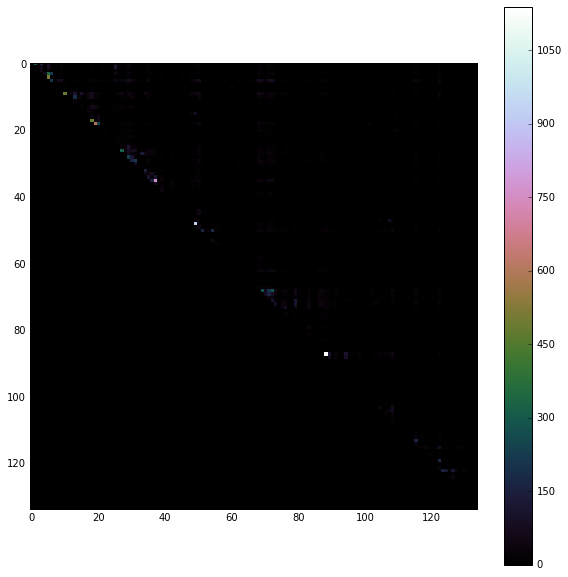

In [160]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
plt.imshow(ukb_kinpair_mat,cmap='cubehelix', interpolation = 'nearest')
plt.colorbar()
plt.show()

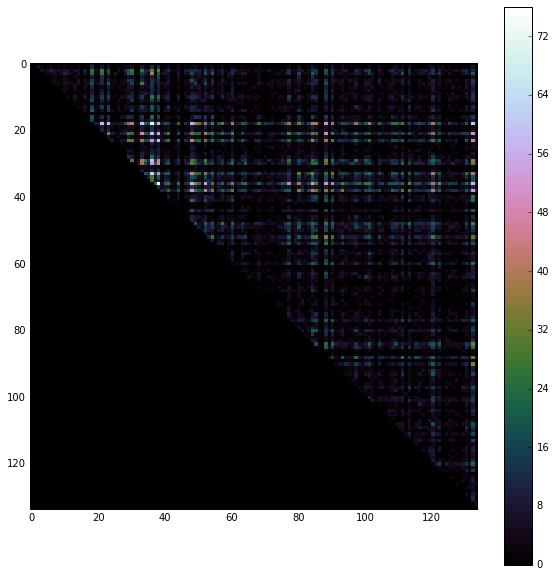

In [144]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
im = ax.imshow(sim_kinpair_mat,cmap='cubehelix', interpolation = 'nearest')
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()

In [101]:
# next: lots of simulations, find average, to define the 'null' map.
# then actually place on qgis, with lines connecting the nuts3 centroids, compared to real map
numSims = 1000
sim_mat = np.zeros([len(nutsID_list), len(nutsID_list), numSims])

for n in range(numSims):
    d = sim_nuts_kin_pairs(38967,census_fracs_for_nuts,nutsDict)
    m = kinpair_dict_to_mat(d, nutsID_list)
    sim_mat[:,:,n] = m

In [102]:
np.save('1000sim_nuts3_38967connections.npy',sim_mat)

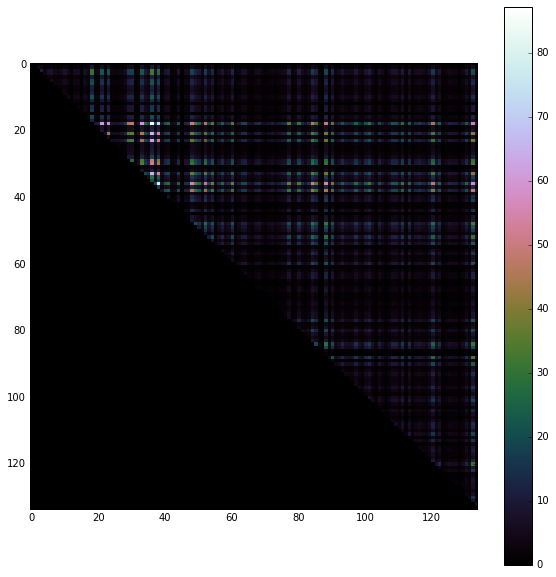

In [185]:
sim_mat = np.load('1000sim_nuts3_38967connections.npy')
x = np.mean(sim_mat,2)
fig, ax = plt.subplots(1, 1, figsize = (10,10))
im = ax.imshow(x,cmap='cubehelix', interpolation = 'nearest')
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()




# NOW FOR NUTS1 regions!

In [136]:
# ukb: convert connections dictionary (ukb_nuts3_pair_counts) to nuts1 => ukb_nuts1_pair_counts
    # export to csv for QGIS (corrected, uncorrected)
    # convert to matrix for visualization (corrected, uncorrected)
# sim: convert matrix to dictionary => sim_nuts3_pair_counts
    # export to csv for QGIS
    # convert to matrix for visualization

# To do the above, need:
# 1. code to convert nuts3 sim matrix (sim_mat) to a dictionary
# 2. code to convert nuts3 connections dictionary to a nuts1 connections dictionary
# 3. code to convert nuts1 connections dictionary to nuts1 matrix 
    # ... should be able to use kinpair_dict_to_mat()
# 4. code to convert nuts1 connections dictionary to csv for qgis (corrected & uncorrected)
    # should be able to use code from home_nm notebook

In [124]:
# 1. code to convert nuts3 sim matrix (sim_mat) to a dictionary
def nuts3_matrix_to_dict(m, nuts3_ids):
    nuts3_ids = sorted(nuts3_ids)
    d = {}
    for i in np.arange(len(nuts3_ids)):
        region1 = nuts3_ids[i]
        for j in np.arange(i+1,len(nuts3_ids)):
            region2 = nuts3_ids[j]
            k = ','.join([region1,region2])
            d[k] = m[i,j]
    return d

In [125]:
sim_nuts_mat = np.mean(sim_mat,2)
nuts3_ids = sorted(nutsIDs)
sim_nuts3_pair_counts = nuts3_matrix_to_dict(sim_nuts_mat, nuts3_ids)

In [132]:
# 2. code to convert nuts3 connections dictionary to a nuts1 connections dictionary
# nuts3 connections dictionary = sim_nuts3_pair_counts or ukb_nuts3_pair_counts

def nuts3dict_to_nuts1dict(nuts3dict):
    d = {}
    for pair in sorted(nuts3dict.keys()):
        region1, region2 = [x[:-2] for x in pair.split(',')]
        if region1 != region2:
            k = ','.join([region1,region2])
            if k in d.keys():
                d[k] += nuts3dict[pair]
            else:
                d[k] = nuts3dict[pair]
    return d

In [188]:
# let's look at these nuts3dict dictionaries before going on . . . 

d = ukb_nuts3_pair_counts
o = open('tmp222.csv','w')
o.write('r1,r2,pairs\n')
for k in d.keys():
    o.write(k + ',' + str(d[k]) + '\n')
o.close()

In [189]:
df = pd.read_csv('tmp222.csv')
ttt = 0
for id in nuts1_ids:
    tot = np.sum(df[df['r1'].str.contains(id)]['pairs'].values)
    print(id,tot)
    ttt += tot
print(ttt)
# why does london (UKI) have so FEW connections? in sim data?
# maybe because I forced the pairs to NOT be between same regions . . . ?

UKC 6599
UKD 7816
UKE 5517
UKF 3720
UKG 3824
UKH 1265
UKI 3875
UKJ 1506
UKK 2462
UKL 656
UKM 1727
38967


In [135]:
ukb_nuts1_pair_counts = nuts3dict_to_nuts1dict(ukb_nuts3_pair_counts)
sim_nuts1_pair_counts = nuts3dict_to_nuts1dict(sim_nuts3_pair_counts)

In [182]:
# 3. code to convert nuts1 connections dictionary to nuts1 matrix 
    # ... should be able to use kinpair_dict_to_mat()
ids = []
for k in sim_nuts1_pair_counts.keys():
    ids.extend(k.split(','))
nuts1_ids = sorted(list(set(ids)))

sim_nuts1_kinpair_mat = kinpair_dict_to_mat(sim_nuts1_pair_counts, nuts1_ids)
ukb_nuts1_kinpair_mat = kinpair_dict_to_mat(ukb_nuts1_pair_counts, nuts1_ids)

In [196]:
d = ukb_nuts1_pair_counts
# this doesn't match up with my previous 'where are your kin' maps
tfile = 'tmp.csv'
o = open(tfile,'w')
o.write('r1,r2,pairs\n')
for k in sorted(d.keys()):
    o.write(k + ',' + str(d[k]) + '\n')
o.close()
df = pd.read_csv(tfile)
df[df['r2'] == 'UKM']

,r1,r2,pairs
9,UKC,UKM,430
18,UKD,UKM,376
26,UKE,UKM,373
33,UKF,UKM,230
39,UKG,UKM,245
44,UKH,UKM,114
48,UKI,UKM,407
51,UKJ,UKM,259
53,UKK,UKM,191
54,UKL,UKM,107


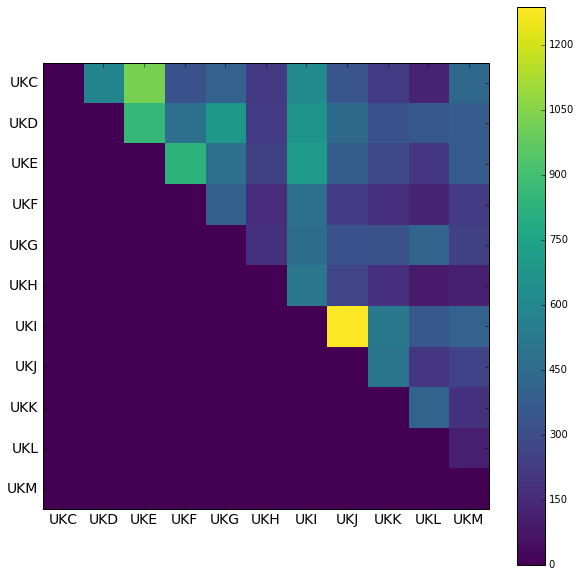

In [187]:
x = ukb_nuts1_kinpair_mat
fig, ax = plt.subplots(1, 1, figsize = (10,10))
im = ax.imshow(x,cmap='viridis', interpolation = 'nearest')
ax.set_xticks(np.arange(len(nuts1_ids)))
ax.set_xticklabels(nuts1_ids,fontsize=14)
ax.set_yticks(np.arange(len(nuts1_ids)))
ax.set_yticklabels(nuts1_ids,fontsize=14)
cbar = ax.figure.colorbar(im, ax=ax)
plt.show()